In [1]:
import pandas as pd
import numpy as np

import datetime
import pytz
import requests
from pandas.io.json import json_normalize

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IEX_API_URL_TEMPLATE = 'https://api.iextrading.com/1.0/stock/{}/chart/5y'

djia_tickers = [
    'BA',   'PFE', 'MCD', 'WMT', 'KO',   'MRK',  'HD',   'V',   'JNJ',  'VZ',
    'CSCO', 'AXP', 'TRV', 'DIS', 'MSFT', 'UNH',  'DWDP', 'CAT', 'AAPL', 'UTX',
    'MMM',  'JPM', 'IBM', 'GS',  'XOM',  'INTC', 'NKE',  'CVX', 'PG',   'WBA' ]

In [3]:
def format_dataset(df):
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['week'] = df.date.dt.week
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df['timestamp'] = df.date.values.astype(np.int64)

    return df.drop(['label',
                    'change', 'changeOverTime', 'changePercent',
                    'high', 'low', 'open',
                    'unadjustedVolume', 'volume', 'vwap'],
                   axis=1)


def get_dataset_from_ticker(ticker_symbol):
    r = requests.get(url = IEX_API_URL_TEMPLATE.format(ticker_symbol.lower()))
    df = json_normalize(r.json())

    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    df.insert(loc=0, column='symbol', value=ticker_symbol)

    return format_dataset(df)


def get_djia_dataset():
    df = None

    for ticker_symbol in djia_tickers:
        if df is None:
            df = get_dataset_from_ticker(ticker_symbol)
        else:
            df = df.append(get_dataset_from_ticker(ticker_symbol))

    return df


def update_djia_dataset(djia_ds):
    last_djia_ds = get_djia_dataset()
    return djia_ds.append(last_djia_ds).drop_duplicates(['symbol', 'date'], keep='last')


def save_dataset_to_file(ds, file_name):
    with open(file_name, 'wb') as fp:
        pickle.dump(ds, fp)

        
def load_dataset_from_file(file_name):
    with open(file_name, 'rb') as fp:
        return pickle.load(fp)



### -----------------------

In [49]:
closing_days = []

def load_closing_days(closing_days_file='closing_days.txt'):
    closing_days.clear()

    with open(closing_days_file) as f:
        lines = f.readlines()

    for line in lines:
        closing_days.append(datetime.datetime.strptime(line.strip(), '%Y-%m-%d'))

In [50]:
load_closing_days()

In [51]:
def is_trading_day(date):
    day_of_week = date.weekday()
    if day_of_week == 5 or day_of_week == 6 or date in closing_days:
        return False
    else:
        return True


def get_trading_days_in_range(start_date, end_date):
    trading_days = []

    current = start_date
    while (current <= end_date):
        if is_trading_day(current):
            trading_days.append(current)
        current += datetime.timedelta(days=1)

    return trading_days

In [52]:
def days_in_range(start_date, end_date):
    days = []

    current = start_date
    while (current <= end_date):
        days.append(current)
        current += datetime.timedelta(days=1)

    return days

In [53]:
x = get_trading_days_in_range(
        datetime.datetime.strptime('2019-04-01', '%Y-%m-%d'),
        datetime.datetime.strptime('2019-04-30', '%Y-%m-%d'))

for d in x:
    print(d)

2019-04-01 00:00:00
2019-04-02 00:00:00
2019-04-03 00:00:00
2019-04-04 00:00:00
2019-04-05 00:00:00
2019-04-08 00:00:00
2019-04-09 00:00:00
2019-04-10 00:00:00
2019-04-11 00:00:00
2019-04-12 00:00:00
2019-04-15 00:00:00
2019-04-16 00:00:00
2019-04-17 00:00:00
2019-04-18 00:00:00
2019-04-22 00:00:00
2019-04-23 00:00:00
2019-04-24 00:00:00
2019-04-25 00:00:00
2019-04-26 00:00:00
2019-04-29 00:00:00
2019-04-30 00:00:00


### -----------------------

In [ ]:
djia_ds = load_dataset_from_file('djia_20140303-20190228.pkl')
djia_ds = update_djia_dataset(djia_ds)
save_dataset_to_file(djia_ds, 'djia_{:%Y%m%d}-{:%Y%m%d}.pkl'.format(min(djia_ds.date), max(djia_ds.date)))

### -----------------------

In [ ]:
train = djia_ds.query("symbol == 'AAPL' and date >= '2015-06-23' and date <= '2018-06-22'")
valid = djia_ds.query("symbol == 'AAPL' and date >= '2018-06-23' and date <= '2018-09-22'")

plt.plot(train.date, train.close, label='Close Price history')
plt.plot(valid.date, valid.close, label='Close Price history')

### -----------------------

In [54]:
djia_ds = load_dataset_from_file('djia_20140303-20190315.pkl')
poc_ds = djia_ds.query("symbol == 'AAPL' and date >= '2014-03-03' and date <= '2019-03-15'")

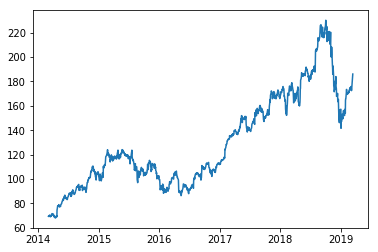

In [55]:
plt.plot(poc_ds.date, poc_ds.close, label='Training')

In [56]:
opening_days = []

for x in poc_ds.date:
    opening_days.append(x)
    #print(x)

In [59]:
#days_poc = days_in_range(
#        datetime.datetime.strptime('2014-03-03', '%Y-%m-%d'),
#        datetime.datetime.strptime('2018-12-31', '%Y-%m-%d'))

#for x in days_poc:
#    if x not in opening_days:
#        print(x)

for x in opening_days:
    if x not in closing_days:
        print(x)


2014-03-03 00:00:00
2014-03-04 00:00:00
2014-03-05 00:00:00
2014-03-06 00:00:00
2014-03-07 00:00:00
2014-03-10 00:00:00
2014-03-11 00:00:00
2014-03-12 00:00:00
2014-03-13 00:00:00
2014-03-14 00:00:00
2014-03-17 00:00:00
2014-03-18 00:00:00
2014-03-19 00:00:00
2014-03-20 00:00:00
2014-03-21 00:00:00
2014-03-24 00:00:00
2014-03-25 00:00:00
2014-03-26 00:00:00
2014-03-27 00:00:00
2014-03-28 00:00:00
2014-03-31 00:00:00
2014-04-01 00:00:00
2014-04-02 00:00:00
2014-04-03 00:00:00
2014-04-04 00:00:00
2014-04-07 00:00:00
2014-04-08 00:00:00
2014-04-09 00:00:00
2014-04-10 00:00:00
2014-04-11 00:00:00
2014-04-14 00:00:00
2014-04-15 00:00:00
2014-04-16 00:00:00
2014-04-17 00:00:00
2014-04-21 00:00:00
2014-04-22 00:00:00
2014-04-23 00:00:00
2014-04-24 00:00:00
2014-04-25 00:00:00
2014-04-28 00:00:00
2014-04-29 00:00:00
2014-04-30 00:00:00
2014-05-01 00:00:00
2014-05-02 00:00:00
2014-05-05 00:00:00
2014-05-06 00:00:00
2014-05-07 00:00:00
2014-05-08 00:00:00
2014-05-09 00:00:00
2014-05-12 00:00:00


2017-10-20 00:00:00
2017-10-23 00:00:00
2017-10-24 00:00:00
2017-10-25 00:00:00
2017-10-26 00:00:00
2017-10-27 00:00:00
2017-10-30 00:00:00
2017-10-31 00:00:00
2017-11-01 00:00:00
2017-11-02 00:00:00
2017-11-03 00:00:00
2017-11-06 00:00:00
2017-11-07 00:00:00
2017-11-08 00:00:00
2017-11-09 00:00:00
2017-11-10 00:00:00
2017-11-13 00:00:00
2017-11-14 00:00:00
2017-11-15 00:00:00
2017-11-16 00:00:00
2017-11-17 00:00:00
2017-11-20 00:00:00
2017-11-21 00:00:00
2017-11-22 00:00:00
2017-11-24 00:00:00
2017-11-27 00:00:00
2017-11-28 00:00:00
2017-11-29 00:00:00
2017-11-30 00:00:00
2017-12-01 00:00:00
2017-12-04 00:00:00
2017-12-05 00:00:00
2017-12-06 00:00:00
2017-12-07 00:00:00
2017-12-08 00:00:00
2017-12-11 00:00:00
2017-12-12 00:00:00
2017-12-13 00:00:00
2017-12-14 00:00:00
2017-12-15 00:00:00
2017-12-18 00:00:00
2017-12-19 00:00:00
2017-12-20 00:00:00
2017-12-21 00:00:00
2017-12-22 00:00:00
2017-12-26 00:00:00
2017-12-27 00:00:00
2017-12-28 00:00:00
2017-12-29 00:00:00
2018-01-02 00:00:00


In [66]:
day1 = datetime.datetime.strptime('2014-02-01', '%Y-%m-%d')
day2 = datetime.datetime.strptime('2014-02-01 12:45', '%Y-%m-%d %H:%M')
print((day2-day1).days)


0
